In [37]:
%matplotlib inline
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from utils import *
import re
import datetime as dt

In [2]:
train = pd.read_csv('train_dataset.csv')
test = pd.read_csv('test_dataset.csv')
sample = pd.read_csv('sample_submission.csv')

In [3]:
train.head()

,id,location,fault_severity,event_type 1,event_type 10,event_type 11,event_type 12,event_type 13,event_type 14,event_type 15,...,feature 90 volume,feature 91 volume,feature 92 volume,feature 93 volume,feature 94 volume,feature 95 volume,feature 96 volume,feature 97 volume,feature 98 volume,feature 99 volume
0,14121,location 118,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9320,location 91,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14394,location 152,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8218,location 931,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,14804,location 120,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
xgmat = xgb.DMatrix(train.iloc[:, 3:], label=train.loc[:, 'fault_severity'])

In [34]:
# setup parameters for xgboost
param = {}
# use logistic regression loss
param['objective'] = 'multi:softprob'
param['bst:eta'] = 0.12
param['bst:max_depth'] = 6
param['eval_metric'] = 'mlogloss'
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 3
param['gamma'] = 0.7
param['max_depth'] = 7
param['subsample'] = .5

In [35]:
insample_evaluates = []
outsample_evaluates = []
com_cats = []
num_round = 200
plst = list(param.items())
pattern = r'.*:(?P<evaluate>0.\d*)'
for rid, com_range in enumerate(full_ranges[1:]):
    print(rid)
    col_ids = list_sum(x[1] for x in com_range)
    com_cat = string_sum(x[0] for x in com_range)
    train_x, valid_x, train_y, valid_y = train_test_split(
        train.iloc[:, col_ids].values,
        train.loc[:, 'fault_severity'].values,
        test_size=.333)
    train_xgmat = xgb.DMatrix(train_x, label=train_y)
    valid_xgmat = xgb.DMatrix(valid_x, label=valid_y)
    bst = xgb.train(plst, train_xgmat, num_round)
    evaluate = float(re.search(pattern, str(bst.eval(train_xgmat))).groupdict()['evaluate'])
    insample_evaluates.append(evaluate)
    evaluate = float(re.search(pattern, str(bst.eval(valid_xgmat))).groupdict()['evaluate'])
    outsample_evaluates.append(evaluate)
    com_cats.append(com_cat)
res = pd.DataFrame(
    {'insample_evaluates': insample_evaluates,
     'outsample_evaluates': outsample_evaluates}, index=com_cats)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


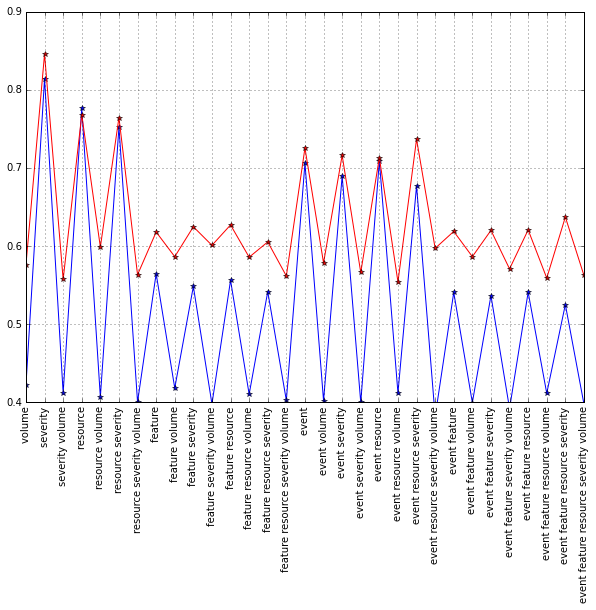

In [36]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
res.loc[:, 'insample_evaluates'].plot(kind='line', ax=ax, rot=90, marker='*', ylim=(0.4, 0.9))
res.loc[:, 'outsample_evaluates'].plot(kind='line', ax=ax, color='r', rot=90, marker='*', ylim=(0.4, 0.9))
plt.xticks(range(len(res.index)), res.index)
plt.grid()
plt.show()

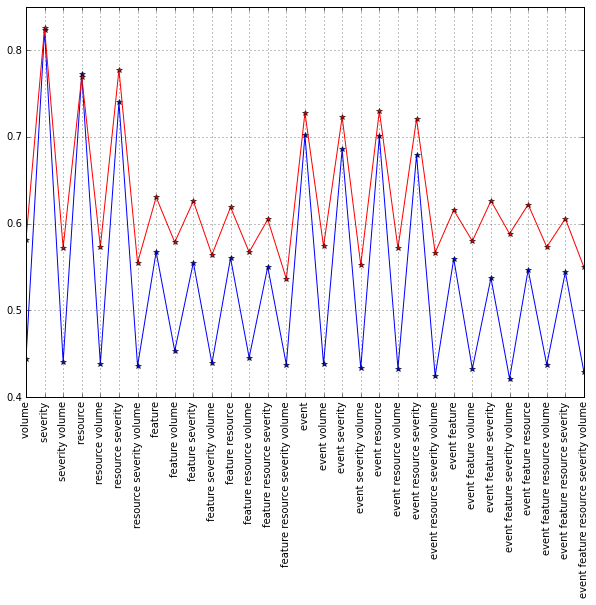

In [43]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
res.loc[:, 'insample_evaluates'].plot(kind='line', ax=ax, rot=90, marker='*')
res.loc[:, 'outsample_evaluates'].plot(kind='line', ax=ax, color='r', rot=90, marker='*')
plt.xticks(range(len(res.index)), res.index)
plt.grid()
plt.show()

In [130]:
# setup parameters for xgboost
param = {}
# use logistic regression loss
param['objective'] = 'multi:softprob'
param['bst:eta'] = 0.12
param['bst:max_depth'] = 6
param['eval_metric'] = 'mlogloss'
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 3
param['subsample'] = .5
insample_evaluates = []
outsample_evaluates = []
com_cats = []
num_round = 200
plst = list(param.items())
pattern = r'.*:(?P<evaluate>0.\d*)'
for rid, com_range in enumerate([10, 30, 50, 100, 300, 500, 1000, 3000]):
    param['gamma'] = com_range
    random_state = int(dt.datetime.today().strftime("%m%d%H%M%S"))
    print(rid)
    train_x, valid_x, train_y, valid_y = train_test_split(
        train.iloc[:, 3:].values,
        train.loc[:, 'fault_severity'].values,
        test_size=.333,
        random_state=random_state)
    train_xgmat = xgb.DMatrix(train_x, label=train_y)
    valid_xgmat = xgb.DMatrix(valid_x, label=valid_y)
    bst = xgb.train(plst, train_xgmat, num_round)
    evaluate = float(re.search(pattern, str(bst.eval(train_xgmat))).groupdict()['evaluate'])
    insample_evaluates.append(evaluate)
    evaluate = float(re.search(pattern, str(bst.eval(valid_xgmat))).groupdict()['evaluate'])
    outsample_evaluates.append(evaluate)
    com_cats.append(com_range)
res = pd.DataFrame(
    {'insample_evaluates': insample_evaluates,
     'outsample_evaluates': outsample_evaluates}, index=com_cats)

0
1
2
3
4
5
6
7


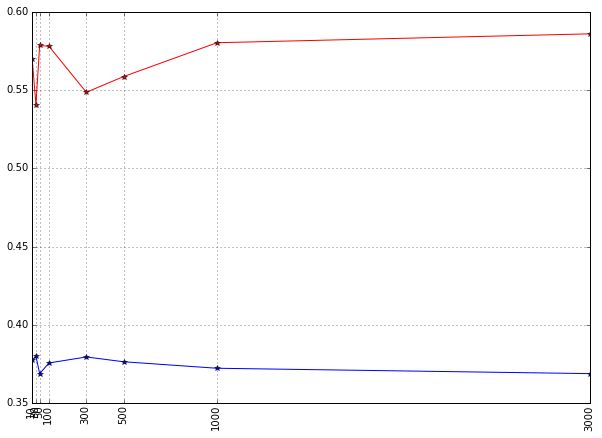

In [129]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
res.loc[:, 'insample_evaluates'].plot(kind='line', ax=ax, rot=90, marker='*')
res.loc[:, 'outsample_evaluates'].plot(kind='line', ax=ax, color='r', rot=90, marker='*')
plt.xticks(res.index, res.index)
plt.grid()
plt.show()

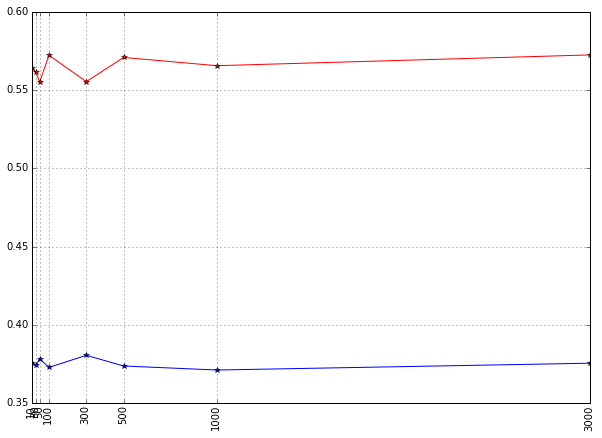

In [131]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
res.loc[:, 'insample_evaluates'].plot(kind='line', ax=ax, rot=90, marker='*')
res.loc[:, 'outsample_evaluates'].plot(kind='line', ax=ax, color='r', rot=90, marker='*')
plt.xticks(res.index, res.index)
plt.grid()
plt.show()

In [112]:
# setup parameters for xgboost
param = {}
# use logistic regression loss
param['objective'] = 'multi:softprob'
param['bst:eta'] = 0.12
param['bst:max_depth'] = 6
param['eval_metric'] = 'mlogloss'
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 3
param['subsample'] = .5
insample_evaluates = []
outsample_evaluates = []
com_cats = []
num_round = 200
plst = list(param.items())
pattern = r'.*:(?P<evaluate>0.\d*)'
for rid, com_range in enumerate([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 20, 25, 30, 35]):
    param['max_depth'] = com_range
    random_state = int(dt.datetime.today().strftime("%m%d%H%M%S"))
    print(rid)
    train_x, valid_x, train_y, valid_y = train_test_split(
        train.iloc[:, 3:].values,
        train.loc[:, 'fault_severity'].values,
        test_size=.333,
        random_state=random_state)
    train_xgmat = xgb.DMatrix(train_x, label=train_y)
    valid_xgmat = xgb.DMatrix(valid_x, label=valid_y)
    bst = xgb.train(plst, train_xgmat, num_round)
    evaluate = float(re.search(pattern, str(bst.eval(train_xgmat))).groupdict()['evaluate'])
    insample_evaluates.append(evaluate)
    evaluate = float(re.search(pattern, str(bst.eval(valid_xgmat))).groupdict()['evaluate'])
    outsample_evaluates.append(evaluate)
    com_cats.append(com_range)
res = pd.DataFrame(
    {'insample_evaluates': insample_evaluates,
     'outsample_evaluates': outsample_evaluates}, index=com_cats)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [122]:
# setup parameters for xgboost
param = {}
# use logistic regression loss
param['objective'] = 'multi:softprob'
param['bst:eta'] = 0.12
param['bst:max_depth'] = 6
param['eval_metric'] = 'mlogloss'
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 3
param['subsample'] = .5
insample_evaluates = []
outsample_evaluates = []
com_cats = []
num_round = 200
plst = list(param.items())
pattern = r'.*:(?P<evaluate>0.\d*)'
for rid, com_range in enumerate([.1, .5, 1, 5, 10, 100, 1000]):
    param['min_child_weight'] = com_range
    random_state = int(dt.datetime.today().strftime("%m%d%H%M%S"))
    print(rid)
    train_x, valid_x, train_y, valid_y = train_test_split(
        train.iloc[:, 3:].values,
        train.loc[:, 'fault_severity'].values,
        test_size=.333,
        random_state=random_state)
    train_xgmat = xgb.DMatrix(train_x, label=train_y)
    valid_xgmat = xgb.DMatrix(valid_x, label=valid_y)
    bst = xgb.train(plst, train_xgmat, num_round)
    evaluate = float(re.search(pattern, str(bst.eval(train_xgmat))).groupdict()['evaluate'])
    insample_evaluates.append(evaluate)
    evaluate = float(re.search(pattern, str(bst.eval(valid_xgmat))).groupdict()['evaluate'])
    outsample_evaluates.append(evaluate)
    com_cats.append(com_range)
res = pd.DataFrame(
    {'insample_evaluates': insample_evaluates,
     'outsample_evaluates': outsample_evaluates}, index=com_cats)

0
1
2
3
4
5
6


In [126]:
# setup parameters for xgboost
param = {}
# use logistic regression loss
param['objective'] = 'multi:softprob'
param['bst:eta'] = 0.12
param['bst:max_depth'] = 6
param['eval_metric'] = 'mlogloss'
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 3
param['subsample'] = .5
insample_evaluates = []
outsample_evaluates = []
com_cats = []
num_round = 200
plst = list(param.items())
pattern = r'.*:(?P<evaluate>0.\d*)'
for rid, com_range in enumerate([.1, .5, 1, 5, 10, 100, 1000]):
    param['max_delta_step'] = com_range
    random_state = int(dt.datetime.today().strftime("%m%d%H%M%S"))
    print(rid, random_state)
    train_x, valid_x, train_y, valid_y = train_test_split(
        train.iloc[:, 3:].values,
        train.loc[:, 'fault_severity'].values,
        test_size=.333,
        random_state=random_state)
    train_xgmat = xgb.DMatrix(train_x, label=train_y)
    valid_xgmat = xgb.DMatrix(valid_x, label=valid_y)
    bst = xgb.train(plst, train_xgmat, num_round)
    evaluate = float(re.search(pattern, str(bst.eval(train_xgmat))).groupdict()['evaluate'])
    insample_evaluates.append(evaluate)
    evaluate = float(re.search(pattern, str(bst.eval(valid_xgmat))).groupdict()['evaluate'])
    outsample_evaluates.append(evaluate)
    com_cats.append(com_range)
res = pd.DataFrame(
    {'insample_evaluates': insample_evaluates,
     'outsample_evaluates': outsample_evaluates}, index=com_cats)

0 123174044
1 123174047
2 123174050
3 123174053
4 123174056
5 123174059
6 123174102


In [ ]:
# setup parameters for xgboost
param = {}
# use logistic regression loss
param['objective'] = 'multi:softprob'
param['bst:eta'] = 0.12
param['bst:max_depth'] = 6
param['eval_metric'] = 'mlogloss'
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 3
param['subsample'] = .5
insample_evaluates = []
outsample_evaluates = []
com_cats = []
num_round = 200
plst = list(param.items())
pattern = r'.*:(?P<evaluate>0.\d*)'
for rid, com_range in enumerate([.1, .2, .3, .4, .5, .6, .7, .8, .9]):
    param['colsample_bytree'] = com_range
    random_state = int(dt.datetime.today().strftime("%m%d%H%M%S"))
    print(rid, random_state)
    train_x, valid_x, train_y, valid_y = train_test_split(
        train.iloc[:, 3:].values,
        train.loc[:, 'fault_severity'].values,
        test_size=.333,
        random_state=random_state)
    train_xgmat = xgb.DMatrix(train_x, label=train_y)
    valid_xgmat = xgb.DMatrix(valid_x, label=valid_y)
    bst = xgb.train(plst, train_xgmat, num_round)
    evaluate = float(re.search(pattern, str(bst.eval(train_xgmat))).groupdict()['evaluate'])
    insample_evaluates.append(evaluate)
    evaluate = float(re.search(pattern, str(bst.eval(valid_xgmat))).groupdict()['evaluate'])
    outsample_evaluates.append(evaluate)
    com_cats.append(com_range)
res = pd.DataFrame(
    {'insample_evaluates': insample_evaluates,
     'outsample_evaluates': outsample_evaluates}, index=com_cats)

In [100]:
# setup parameters for xgboost
param = {}
# use logistic regression loss
param['objective'] = 'multi:softprob'
param['bst:eta'] = 0.12
param['bst:max_depth'] = 6
param['eval_metric'] = 'mlogloss'
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 3
param['subsample'] = .5
insample_evaluates = []
outsample_evaluates = []
com_cats = []
num_round = 200
plst = list(param.items())
pattern = r'.*:(?P<evaluate>0.\d*)'
for rid, com_range in enumerate([.1, .5, 1, 5, 10, 30, 50, 70, 90, 100]):
    param['lambda'] = com_range
    random_state = int(dt.datetime.today().strftime("%m%d%H%M%S"))
    print(rid, random_state)
    train_x, valid_x, train_y, valid_y = train_test_split(
        train.iloc[:, 3:].values,
        train.loc[:, 'fault_severity'].values,
        test_size=.333,
        random_state=random_state)
    train_xgmat = xgb.DMatrix(train_x, label=train_y)
    valid_xgmat = xgb.DMatrix(valid_x, label=valid_y)
    bst = xgb.train(plst, train_xgmat, num_round)
    evaluate = float(re.search(pattern, str(bst.eval(train_xgmat))).groupdict()['evaluate'])
    insample_evaluates.append(evaluate)
    evaluate = float(re.search(pattern, str(bst.eval(valid_xgmat))).groupdict()['evaluate'])
    outsample_evaluates.append(evaluate)
    com_cats.append(com_range)
res = pd.DataFrame(
    {'insample_evaluates': insample_evaluates,
     'outsample_evaluates': outsample_evaluates}, index=com_cats)

0 123171229
1 123171232
2 123171234
3 123171237
4 123171239
5 123171242
6 123171245
7 123171247
8 123171250
9 123171253


In [ ]:
# setup parameters for xgboost
param = {}
# use logistic regression loss
param['objective'] = 'multi:softprob'
param['bst:eta'] = 0.12
param['bst:max_depth'] = 6
param['eval_metric'] = 'mlogloss'
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 3
param['subsample'] = .5
insample_evaluates = []
outsample_evaluates = []
com_cats = []
num_round = 200
plst = list(param.items())
pattern = r'.*:(?P<evaluate>0.\d*)'
for rid, com_range in enumerate([.1, .5, 1, 5, 10, 30, 50, 70, 90, 100]):
    param['alpha'] = com_range
    random_state = int(dt.datetime.today().strftime("%m%d%H%M%S"))
    print(rid, random_state)
    train_x, valid_x, train_y, valid_y = train_test_split(
        train.iloc[:, 3:].values,
        train.loc[:, 'fault_severity'].values,
        test_size=.333,
        random_state=random_state)
    train_xgmat = xgb.DMatrix(train_x, label=train_y)
    valid_xgmat = xgb.DMatrix(valid_x, label=valid_y)
    bst = xgb.train(plst, train_xgmat, num_round)
    evaluate = float(re.search(pattern, str(bst.eval(train_xgmat))).groupdict()['evaluate'])
    insample_evaluates.append(evaluate)
    evaluate = float(re.search(pattern, str(bst.eval(valid_xgmat))).groupdict()['evaluate'])
    outsample_evaluates.append(evaluate)
    com_cats.append(com_range)
res = pd.DataFrame(
    {'insample_evaluates': insample_evaluates,
     'outsample_evaluates': outsample_evaluates}, index=com_cats)

In [44]:
xgmat = xgb.DMatrix(train.iloc[:, 3:], label=train.loc[:, 'fault_severity'])
bst = xgb.train(plst, xgmat, 200)

In [45]:
testmat = xgb.DMatrix(test.iloc[:, 2:])

In [46]:
prob = bst.predict(testmat)

In [47]:
prob

array([[  9.58419323e-01,   4.14050445e-02,   1.75691166e-04],
       [  2.97163814e-01,   8.95997509e-02,   6.13236427e-01],
       [  9.77949262e-01,   2.18781326e-02,   1.72624452e-04],
       ..., 
       [  3.06886226e-01,   5.68169832e-01,   1.24943919e-01],
       [  9.46187854e-01,   5.35393730e-02,   2.72758276e-04],
       [  8.94896150e-01,   1.04191989e-01,   9.11840412e-04]], dtype=float32)

In [48]:
xgbc_prob = pd.DataFrame({
    'id': sample.loc[:, 'id'].values, 
    'predict_0': prob[:, 0],
    'predict_1': prob[:, 1],
    'predict_2': prob[:, 2]})

In [49]:
xgbc_prob.to_csv('xgbc.csv', index=False)

In [51]:
xgbc_prob.head()

,id,predict_0,predict_1,predict_2
0,11066,0.958419,0.041405,0.000176
1,18000,0.297164,0.089600,0.613236
2,16964,0.977949,0.021878,0.000173
3,4795,0.707602,0.280961,0.011436
4,3392,0.165933,0.812566,0.021501
